In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd /content/drive/My\ Drive/dcec
%ls

/content/drive/My Drive/dcec
model.h5  models/  weights/


In [3]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from pathlib import Path
from keras.datasets import mnist
from keras import Model
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from models.dcec import DCEC
from sklearn.manifold import TSNE
import tensorflow as tf
import scipy
import seaborn as sns

from sklearn.metrics.cluster import contingency_matrix

from keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from keras.models import Sequential, Model

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
!nvidia-smi

Sat May 16 12:32:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Replication of Results

### HyperParameters Found in the Paper
- Batch size 256
- Epochs 200

```

In [5]:
img_rows, img_cols = 28, 28
batch_size = 256
(mnist_train_data, mnist_train_labels), (mnist_test_data, mnist_test_labels) = mnist.load_data()
mnist_train_data = mnist_train_data.reshape(mnist_train_data.shape[0], img_rows, img_cols, 1)
mnist_train_data = mnist_train_data.astype('float32')
mnist_train_data /= 255
mnist_test_data = mnist_test_data.reshape(mnist_test_data.shape[0], img_rows, img_cols, 1)
mnist_test_data = mnist_test_data.astype('float32')
mnist_test_data /= 255
print(f'MNIST train shape:  {mnist_train_data.shape}')
print(f'MNIST validation shape: {mnist_test_data.shape}')

MNIST train shape:  (60000, 28, 28, 1)
MNIST validation shape: (10000, 28, 28, 1)


In [6]:
# dcec = keras.models.Sequential()
# dcec.add(keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, input_shape=(28, 28, 1), activation='relu', padding='same', name='conv1'))
# dcec.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, activation='relu', padding='same', name='conv2'))
# dcec.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu', padding='valid', name='conv3'))
# dcec.add(keras.layers.Flatten())
# dcec.add(keras.layers.Dense(units=10, name='dense1'))
# dcec.add(keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=0), name='embeddings'))
# dcec.add(keras.layers.Dense(units=128 * int(28/8) * int(28/8), activation='relu', name='dense2'))
# dcec.add(keras.layers.Reshape( (int(28/8), int(28/8), 128) ))
# dcec.add(keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu', name='tp1'))
# dcec.add(keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding='same', activation='relu', name='tp2'))
# dcec.add(keras.layers.Conv2DTranspose(filters=1, kernel_size=5, strides=2, padding='same', activation='relu', name='tp3'))
# dcec.summary()


def CAE(input_shape=(28, 28, 1), filters=[32, 64, 128, 10], use_norm=False):
    model = keras.models.Sequential()
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    model.add(Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape))
    model.add(Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2'))
    model.add(Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3'))
    model.add(Flatten())
    
    if use_norm:
      model.add(Dense(units=filters[3], name='dense1'))
      model.add(keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=0), name='embedding'))
    else:
      model.add(Dense(units=filters[3], name='embedding'))

    model.add(Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu'))
    model.add(Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2])))
    model.add(Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3'))
    model.add(Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2'))
    model.add(Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1'))
    model.summary()
    return model

cae = CAE()
cae_l2 = CAE(use_norm=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 14, 14, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
embedding (Dense)            (None, 10)                11530     
_________________________________________________________________
dense_1 (Dense)              (None, 1152)              12672     
_________________________________________________________________
reshape_1 (Reshape)          (None, 3, 3, 128)        

In [0]:
cae.compile(optimizer='adam', loss='mse')
cae_l2.compile(optimizer='adam', loss='mse')


# Model without $L_2$ Norm 

In [8]:
epochs = 100

if True:
  checkpoint = ModelCheckpoint("weights/dcec_best_model.hdf5", monitor='loss', verbose=1,
      save_best_only=True, mode='auto', period=50)

  cae.fit(mnist_train_data, 
          mnist_train_data, 
          batch_size=batch_size, 
          epochs=epochs,
          verbose=1)
          # callbacks=[checkpoint])

  cae.save_weights(f"weights/cae_final_model_{epochs}_{batch_size}.h5")
else:
  cae.load_weights(f"weights/cae_final_model_{epochs}_{batch_size}.h5")

Epoch 1/100
60000/60000 [==============================] - 4s 64us/step - loss: 0.0449
Epoch 2/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0199
Epoch 3/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0170
Epoch 4/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0157
Epoch 5/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0149
Epoch 6/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0144
Epoch 7/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.0139
Epoch 8/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0135
Epoch 9/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.0132
Epoch 10/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.0129
Epoch 11/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0127
Epoch 12/100
60000/60000 [===============

# Model with $L_2$ Norm

In [9]:
epochs = 100

if True:
  checkpoint = ModelCheckpoint("weights/dcec_best_model.hdf5", monitor='loss', verbose=1,
      save_best_only=True, mode='auto', period=50)

  cae_l2.fit(mnist_train_data, 
          mnist_train_data, 
          batch_size=batch_size, 
          epochs=epochs,
          verbose=1)
          # callbacks=[checkpoint])

  cae_l2.save_weights(f"weights/cae_l2_final_model_{epochs}_{batch_size}.h5")
else:
  cae_l2.load_weights(f"weights/cae_l2_final_model_{epochs}_{batch_size}.h5")

Epoch 1/100
60000/60000 [==============================] - 3s 42us/step - loss: 0.0493
Epoch 2/100
60000/60000 [==============================] - 2s 38us/step - loss: 0.0265
Epoch 3/100
60000/60000 [==============================] - 2s 38us/step - loss: 0.0224
Epoch 4/100
60000/60000 [==============================] - 2s 38us/step - loss: 0.0203
Epoch 5/100
60000/60000 [==============================] - 2s 38us/step - loss: 0.0190
Epoch 6/100
60000/60000 [==============================] - 2s 38us/step - loss: 0.0180
Epoch 7/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0172
Epoch 8/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0167
Epoch 9/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0162
Epoch 10/100
60000/60000 [==============================] - 2s 38us/step - loss: 0.0157
Epoch 11/100
60000/60000 [==============================] - 2s 38us/step - loss: 0.0154
Epoch 12/100
60000/60000 [===============

In [10]:
%ls -l weights

total 9943
-rw------- 1 root root 1134408 May 16 12:36 cae_final_model_100_256.h5
-rw------- 1 root root 1134408 May 16 12:06 cae_final_model_200_256.h5
-rw------- 1 root root 1135288 May 16 12:40 cae_l2_final_model_100_256.h5
-rw------- 1 root root 1135288 May 16 12:14 cae_l2_final_model_200_256.h5
-rw------- 1 root root 3370136 May 16 10:55 dcec_best_model.hdf5
-rw------- 1 root root 1134464 May 16 10:55 dcec_final_model_200.h5
-rw------- 1 root root 1135288 May 15 17:05 dcec_final_model.h5


In [0]:
def cluster_emb(emb):
  clf = KMeans(n_clusters=10)
  clusters = clf.fit_transform(emb)
  labels = clf.predict(emb)
  return labels, clusters


def m(y_true, y_pred):
  """Find a mapping from ground truth to kmeans labels"""
  cm = contingency_matrix(y_pred, y_true)
  print(cm)
  # print(np.argmax(cm, axis=1))
  _, assignment = scipy.optimize.linear_sum_assignment(-cm)
  print(assignment)
  return np.asarray([assignment[l] for l in y_pred])


def plot_tnse(data, titles, y_true, layout, selection_size=1000):
  tsne_selection = np.random.permutation(len(embeddings))[:selection_size]
  for i, ((_d, _y_pred), _t), in enumerate(zip(data, titles)):
    tsne_emb = TSNE(n_components=2).fit_transform(_d[tsne_selection])
    labels_m = m(y_true, _y_pred)
    plt.subplot(*layout, i+1)
    g = sns.scatterplot(tsne_emb[:, 0], tsne_emb[:, 1], hue=labels[tsne_selection], legend="full", palette="Paired").set_title(f"TNSE of {_t} (N={selection_size})")
    

def report(y_true, labels_unmapped):
  mapping = m(y_true, labels_unmapped)
  print(classification_report(y_true, mapping))
  print("Accuracy: ", (y_true == mapping).mean())


In [0]:
# Get emb with l2
encoder = keras.Model(inputs=cae_l2.input, outputs=cae_l2.get_layer(name='embedding').output)
embeddings = encoder.predict(mnist_test_data) 

# Get emb without l2
encoder_no_l2 = keras.Model(inputs=cae.input, outputs=cae.get_layer(name='embedding').output)
embeddings_no_l2 = encoder.predict(mnist_test_data) 

# Labels
labels, clusters = cluster_emb(embeddings)
labels_no_l2, cluster_no_l2 = cluster_emb(embeddings_no_l2)

In [20]:
print("REPORT WITH L2")
report(mnist_test_labels, labels)

REPORT WITH L2
[[  1   2   0  11   2   0 960   4   0   0]
 [  1 462   0   0   0   4   0   0   0 668]
 [ 11   2   5   6  14 921  48  22   0   3]
 [927   0   1   0  24  14   4  23  10   7]
 [  0  27 934   8   4   0   0   1   1   7]
 [214   7   1   8   5   0   5  40 605   7]
 [  0  31   3 844   0   0  19  14  32  15]
 [  0  21   9   0 966  12   6   5   0   9]
 [ 16   9   5   1  10   1   6 920   3   3]
 [ 12  20 377   0 545   1  19  15   2  18]]
[6 9 5 0 2 8 3 4 7 1]
              precision    recall  f1-score   support

           0       0.01      0.01      0.01       980
           1       0.91      0.59      0.71      1135
           2       0.01      0.01      0.01      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00  

In [15]:
print("REPORT WITHOUT L2")
report(mnist_test_labels, labels_no_l2)

REPORT WITHOUT L2
[7 9 6 1 2 4 5 8 0 3]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       980
           1       0.91      0.59      0.72      1135
           2       0.97      0.90      0.93      1032
           3       0.81      0.92      0.86      1010
           4       0.70      0.95      0.81       982
           5       0.93      0.72      0.81       892
           6       0.96      0.88      0.92       958
           7       0.62      0.94      0.75      1028
           8       0.88      0.94      0.91       974
           9       0.04      0.02      0.03      1009

    accuracy                           0.78     10000
   macro avg       0.77      0.78      0.77     10000
weighted avg       0.77      0.78      0.76     10000

Accuracy:  0.7811


[3 9 4 6 7 2 0 8 5 1]
[7 9 6 1 2 4 5 8 0 3]
[3 9 4 6 7 2 0 8 5 1]
[7 9 6 1 2 4 5 8 0 3]


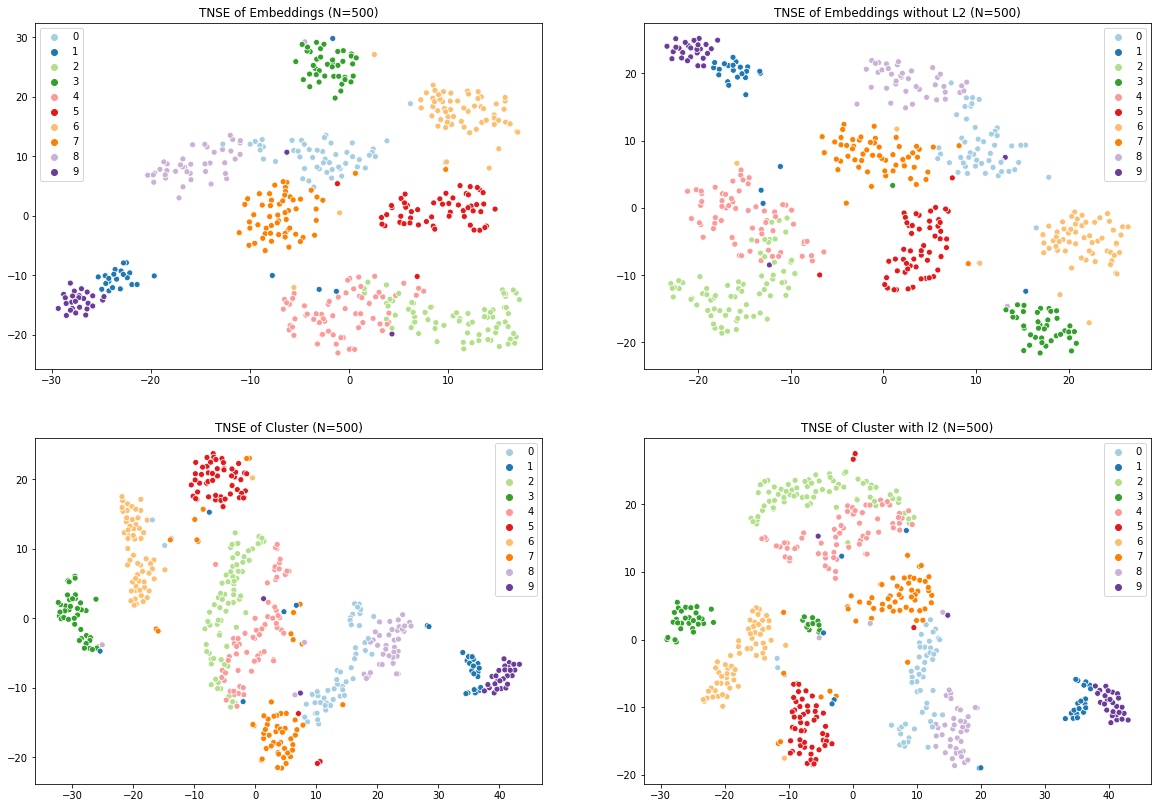

In [16]:
data = [(embeddings, labels), (embeddings_no_l2, labels_no_l2), (clusters, labels), (cluster_no_l2, labels_no_l2)]
titles = ['Embeddings', 'Embeddings without L2' , 'Cluster', 'Cluster with l2']

plt.figure(figsize=(20,14))
plot_tnse(data, titles, mnist_test_labels, (2,2), 500)
plt.show()

In [0]:
plot_roc

In [0]:
# def plot_tsne(data: np.ndarray,
#               labels: np.ndarray,
#               dataset_name: np.ndarray,
#               num_samples_per_class: int = 100) -> None:
#     unique_labels = np.unique(labels)
#     x_tsne = np.array([])
#     for i in range(len(unique_labels)):
#         label_ix = np.argwhere(unique_labels[i] == labels).flatten()
#         random_labels_ix = np.random.choice(label_ix, num_samples_per_class)
#         random_label_data = data[random_labels_ix, :]
#         random_label_data = np.reshape(random_label_data, (num_samples_per_class, -1))
#         if i == 0:
#             x_tsne = random_label_data
#         else:
#             x_tsne = np.vstack((x_tsne, random_label_data))
#     tsne_emb = TSNE(n_components=2).fit_transform(x_tsne)
#     for i in range(len(unique_labels)):
#         rgb = np.random.rand(3,)
#         start_slice = (i)*num_samples_per_class
#         stop_slice = (i+1)*num_samples_per_class
#         x_plot = tsne_emb[()]
#         plt.scatter(tsne_emb[start_slice:stop_slice, 0], tsne_emb[start_slice:stop_slice,1], c=[rgb], s=10, alpha=0.5)
#     plt.title(f'T-SNE features {dataset_name}')
#     plt.legend(unique_labels)
#     plt.show()
    
# plot_tsne(mnist_test_data, 
#           mnist_test_labels, 
#           dataset_name='MNIST',
#           num_samples_per_class=100)


# plot_tsne(clusters, 
#           mnist_test_labels, 
#           dataset_name='MNIST',
#           num_samples_per_class=100)

# plot_tsne(embeddings, 
#           mnist_test_labels, 
#           dataset_name='MNIST',
#           num_samples_per_class=100)